In [19]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from glob import glob
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision.models import resnet34
from scipy.spatial.distance import cdist
import numpy as np
from imageio import imread

from deepface import DeepFace # feature extractor
import pandas as pd

In [3]:
ORI_IMG_DIR = 'E:/datasets/pubfig83' # original images
COR_IMG_DIR = 'E:/datasets/pubfig83-corr' # corrected images

In [5]:
persons = os.listdir(ORI_IMG_DIR)

# Extract features

In [25]:
def extract_features(corrected=False):
    img_dir = COR_IMG_DIR if corrected else ORI_IMG_DIR
    row_list = []
    i = 0
    for person in persons:
        j = 0
        imgs = os.listdir(os.path.join(img_dir, person))
        for img in imgs:
            # Get img
            img_path = os.path.join(img_dir, person, img)
            
            # extract
            try:
                features = DeepFace.represent(img_path)
            except ValueError:
                features = None
            
            # save
            row_list.append(pd.Series({
                'Person': person,
                'Image': img,
                'Feature': features
            }))

            if j % 10 == 9:
                print(f"[Person {i+1}/{83}, Image {j+1}/{len(imgs)}] {person}/{img}")
            j += 1
        i += 1
    
    return row_list

In [26]:
cor_row_list = extract_features(corrected=True)

[Person 1/83, Image 10/108] Adam Sandler/134.jpg
[Person 1/83, Image 20/108] Adam Sandler/17.jpg
[Person 1/83, Image 30/108] Adam Sandler/198.jpg
[Person 1/83, Image 40/108] Adam Sandler/222.jpg
[Person 1/83, Image 50/108] Adam Sandler/245.jpg
[Person 1/83, Image 60/108] Adam Sandler/277.jpg
[Person 1/83, Image 70/108] Adam Sandler/303.jpg
[Person 1/83, Image 80/108] Adam Sandler/42.jpg
[Person 1/83, Image 90/108] Adam Sandler/60.jpg
[Person 1/83, Image 100/108] Adam Sandler/77.jpg
[Person 2/83, Image 10/103] Alec Baldwin/12.jpg
[Person 2/83, Image 20/103] Alec Baldwin/167.jpg
[Person 2/83, Image 30/103] Alec Baldwin/188.jpg
[Person 2/83, Image 40/103] Alec Baldwin/200.jpg
[Person 2/83, Image 50/103] Alec Baldwin/223.jpg
[Person 2/83, Image 60/103] Alec Baldwin/259.jpg
[Person 2/83, Image 70/103] Alec Baldwin/30.jpg
[Person 2/83, Image 80/103] Alec Baldwin/50.jpg
[Person 2/83, Image 90/103] Alec Baldwin/70.jpg
[Person 2/83, Image 100/103] Alec Baldwin/94.jpg
[Person 3/83, Image 10/214]

In [61]:
ori_row_list = extract_features(corrected=False)

[Person 1/83, Image 10/108] Adam Sandler/134.jpg
[Person 1/83, Image 20/108] Adam Sandler/17.jpg
[Person 1/83, Image 30/108] Adam Sandler/198.jpg
[Person 1/83, Image 40/108] Adam Sandler/222.jpg
[Person 1/83, Image 50/108] Adam Sandler/245.jpg
[Person 1/83, Image 60/108] Adam Sandler/277.jpg
[Person 1/83, Image 70/108] Adam Sandler/303.jpg
[Person 1/83, Image 80/108] Adam Sandler/42.jpg
[Person 1/83, Image 90/108] Adam Sandler/60.jpg
[Person 1/83, Image 100/108] Adam Sandler/77.jpg
[Person 2/83, Image 10/103] Alec Baldwin/12.jpg
[Person 2/83, Image 20/103] Alec Baldwin/167.jpg
[Person 2/83, Image 30/103] Alec Baldwin/188.jpg
[Person 2/83, Image 40/103] Alec Baldwin/200.jpg
[Person 2/83, Image 50/103] Alec Baldwin/223.jpg
[Person 2/83, Image 60/103] Alec Baldwin/259.jpg
[Person 2/83, Image 70/103] Alec Baldwin/30.jpg
[Person 2/83, Image 80/103] Alec Baldwin/50.jpg
[Person 2/83, Image 90/103] Alec Baldwin/70.jpg
[Person 2/83, Image 100/103] Alec Baldwin/94.jpg
[Person 3/83, Image 10/214]

In [28]:
df1 = pd.DataFrame(cor_row_list)
df1.to_csv('df1.csv')

In [62]:
df2 = pd.DataFrame(ori_row_list)
df2.to_csv('df2.csv')

# Analyze

In [173]:
df1 = pd.read_csv('df1.csv', index_col=0)
df2 = pd.read_csv('df2.csv', index_col=0)

In [174]:
print(f"df1 has {sum(df1['Feature'].isna())} row with feature is NaN")
print(f"df2 has {sum(df2['Feature'].isna())} row with feature is NaN")

na_idx1 = df1['Feature'].isna()
na_idx2 = df2['Feature'].isna()
na_both = na_idx1 & na_idx2
print(f"There are {sum(na_both)} images that make both df1['Feature'] and df2['Feature'] is NaN")
na_idx1_only = na_idx1 ^ na_both
print(f"There are {sum(na_idx1_only)} images that make only df1['Feature'] is NaN")
na_idx2_only = na_idx2 ^ na_both
print(f"There are {sum(na_idx2_only)} images that make only df2['Feature'] is NaN")
na_any = na_idx1 | na_idx2
print(f"There are {sum(na_any)} images that make df1['Feature'] or df2['Feature'] is NaN")

df1 has 878 row with feature is NaN
df2 has 776 row with feature is NaN
There are 700 images that make both df1['Feature'] and df2['Feature'] is NaN
There are 178 images that make only df1['Feature'] is NaN
There are 76 images that make only df2['Feature'] is NaN
There are 954 images that make df1['Feature'] or df2['Feature'] is NaN


In [175]:
df = df1[~na_any]
df = df.rename(columns={"Feature": "Cor feature"})
df["Ori feature"] = df2[~na_any]['Feature']
df

,Person,Image,Cor feature,Ori feature
0,Adam Sandler,103.jpg,"[0.010197109542787075, 0.012470049783587456, -...","[0.009156988002359867, 0.008892667479813099, -..."
1,Adam Sandler,108.jpg,"[0.004341161344200373, -0.004892963450402021, ...","[0.00925825722515583, -0.0046034217812120914, ..."
2,Adam Sandler,11.jpg,"[0.004731663968414068, -0.0021331338211894035,...","[0.0020495769567787647, -0.0032954649068415165..."
3,Adam Sandler,111.jpg,"[0.010774359107017517, -0.004141064360737801, ...","[0.012978671118617058, -0.002462312811985612, ..."
4,Adam Sandler,114.jpg,"[0.005583297461271286, -0.0014641963643953204,...","[0.007418016903102398, -0.00041870109271258116..."
...,...,...,...,...
13831,Zac Efron,9.jpg,"[0.010080081410706043, -0.002817135537043214, ...","[0.00762253487482667, -0.00013328659406397492,..."
13832,Zac Efron,90.jpg,"[0.011018656194210052, -0.006760075222700834, ...","[0.010983582586050034, -0.0035819357726722956,..."
13833,Zac Efron,91.jpg,"[0.0006183265359140933, -0.006599308457225561,...","[0.0025750938802957535, -0.0045439256355166435..."
13836,Zac Efron,96.jpg,"[0.022524552419781685, -0.008589567616581917, ...","[0.019775645807385445, -0.004953277297317982, ..."


## Calc intracluster distances

In [187]:
row_list = []
i = 0
for person in df['Person'].unique():
    def calc_mean(corr=False):
        column_name = 'Cor feature' if corr else 'Ori feature'
        features = df[df['Person'] == person][column_name]
        features = np.array([eval(f) for f in features])
        mean = cdist(features, features).mean()
        return mean
    
    m1 = calc_mean(corr=True)
    m2 = calc_mean(corr=False)

    row_list.append({
        "Person": person,
        "Mean distance (cor)": m1,
        "Mean distance (ori)": m2
    })
    print(f"[{i+1}/{83}] {person}: cor {m1:.2f}, ori {m2:.2f}")
    i += 1
dists = pd.DataFrame(row_list)

[1/83] Adam Sandler: cor 0.43, ori 0.44
[2/83] Alec Baldwin: cor 0.43, ori 0.44
[3/83] Angelina Jolie: cor 0.63, ori 0.65
[4/83] Anna Kournikova: cor 0.61, ori 0.60
[5/83] Ashton Kutcher: cor 0.58, ori 0.59
[6/83] Avril Lavigne: cor 0.58, ori 0.58
[7/83] Barack Obama: cor 0.43, ori 0.44
[8/83] Ben Affleck: cor 0.49, ori 0.49
[9/83] Beyonce Knowles: cor 0.54, ori 0.54
[10/83] Brad Pitt: cor 0.54, ori 0.55
[11/83] Cameron Diaz: cor 0.60, ori 0.60
[12/83] Cate Blanchett: cor 0.60, ori 0.60
[13/83] Charlize Theron: cor 0.59, ori 0.59
[14/83] Christina Ricci: cor 0.60, ori 0.61
[15/83] Claudia Schiffer: cor 0.58, ori 0.57
[16/83] Clive Owen: cor 0.45, ori 0.46
[17/83] Colin Farrell: cor 0.47, ori 0.48
[18/83] Colin Powell: cor 0.37, ori 0.37
[19/83] Cristiano Ronaldo: cor 0.50, ori 0.50
[20/83] Daniel Craig: cor 0.44, ori 0.44
[21/83] Daniel Radcliffe: cor 0.51, ori 0.52
[22/83] David Beckham: cor 0.50, ori 0.50
[23/83] David Duchovny: cor 0.51, ori 0.51
[24/83] Denise Richards: cor 0.61, o

In [188]:
dists

,Person,Mean distance (cor),Mean distance (ori)
0,Adam Sandler,0.431570,0.435745
1,Alec Baldwin,0.430332,0.439204
2,Angelina Jolie,0.633261,0.646883
3,Anna Kournikova,0.605261,0.602106
4,Ashton Kutcher,0.584596,0.594678
...,...,...,...
78,Uma Thurman,0.650944,0.648546
79,Victoria Beckham,0.579999,0.577336
80,Viggo Mortensen,0.547281,0.550824
81,Will Smith,0.398517,0.404922


In [189]:
dists.mean()

Mean distance (cor)    0.539691
Mean distance (ori)    0.542865
dtype: float64

## Calc intercluster distances

In [ ]:
corr = False

cor_centers = []
ori_centers = []

for person in df['Person'].unique():
    def calc_center(corr=True):
        column_name = 'Cor feature' if corr else 'Ori feature'
        features = df[df['Person'] == person][column_name]
        features = np.array([eval(f) for f in features])
        center = features.mean(axis=0)
        return center
    cor_centers.append(calc_center(corr=True))
    ori_centers.append(calc_center(corr=False))

cor_centers = np.array(cor_centers)
ori_centers = np.array(ori_centers)

In [221]:
cor_centers.shape, ori_centers.shape

((83, 2622), (83, 2622))

In [223]:
cdist(cor_centers, cor_centers).mean()

0.49003427514461867

In [224]:
cdist(ori_centers, ori_centers).mean()

0.5011735542832276

# What's behind

In [210]:
from imageio import imread

def get_rand_imgs():
    indices = np.random.choice(5000, size=16, replace=False)

    imgs = []

    for i in indices:
        row = df.iloc[i]
        file1 = os.path.join(ORI_IMG_DIR, row['Person'], row['Image'])
        file2 = os.path.join(COR_IMG_DIR, row['Person'], row['Image'])
        img1 = imread(file1)
        img2 = imread(file2)
        imgs.append((img1, img2))

    return imgs


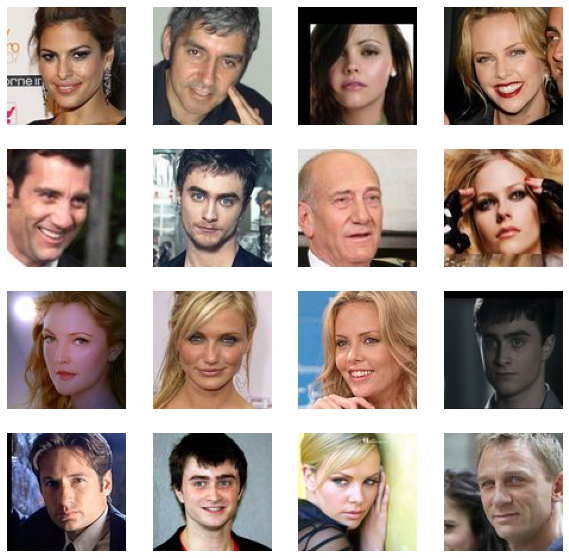

In [215]:
# Original images

imgs = get_rand_imgs()

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i][0])
    plt.axis("off")
plt.show()

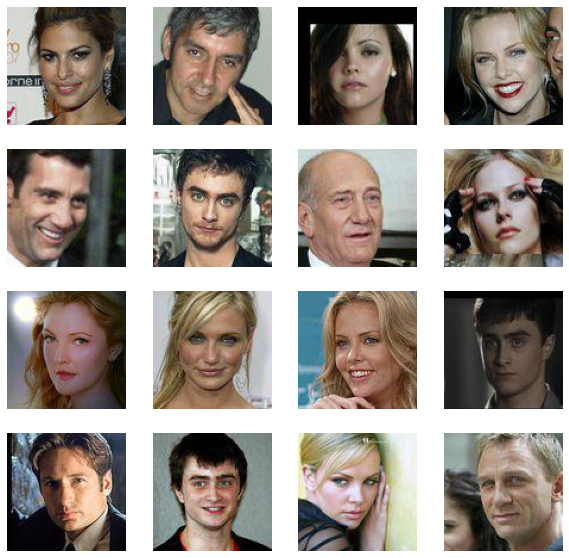

In [216]:
# Corrected images

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i][1])
    plt.axis("off")
plt.show()